In [10]:
# Blind Source Separation using ICA
#
# Objective:
# Use ICA to separate mixed audio signals (Cocktail Party Problem)
#
# Tasks:
# 1. Download or load 2 audio files (e.g., speech + music)
# 2. Create mixed signals by applying a random mixing matrix
# 3. Apply FastICA algorithm to separate original sources
# 4. Compare separated signals with original signals using correlation
# 5. Plot waveforms before and after ICA

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.io import wavfile
import IPython.display as ipd
import warnings


In [11]:
# Suppress warnings from audio file reading
warnings.filterwarnings("ignore", "WAVE file_base .* does not contain a WAVE_FORMAT_EXTENSIBLE chunk..*")

# --- 1. Load Audio Files ---
print("Loading audio files...")
try:
    sr1, s1 = wavfile.read('talk.wav')
    sr2, s2 = wavfile.read('music.wav')
except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Audio files 'talk.wav' and 'music.wav' not found.")
    print("Please download them from: https://share.google/qFcicNdfrceuUzEKR")
    print("And place them in the same directory as this script.")
    print("-------------\n")
    exit()


# Convert to mono if stereo
if s1.ndim > 1:
    s1 = s1.mean(axis=1)
if s2.ndim > 1:
    s2 = s2.mean(axis=1)

# Make lengths equal
min_len = min(len(s1), len(s2))
s1, s2 = s1[:min_len], s2[:min_len]

# Normalize signals
s1 = s1 / np.max(np.abs(s1))
s2 = s2 / np.max(np.abs(s2))

S = np.c_[s1, s2]  # Shape (n_samples, 2)
print(f"Shape of original sources: {S.shape}")

Loading audio files...
Shape of original sources: (220568, 2)



Mixing matrix (A):
 [[0.51639863 0.57066759]
 [0.02847423 0.17152166]]

Playing mixed signal 1 (check your audio output):


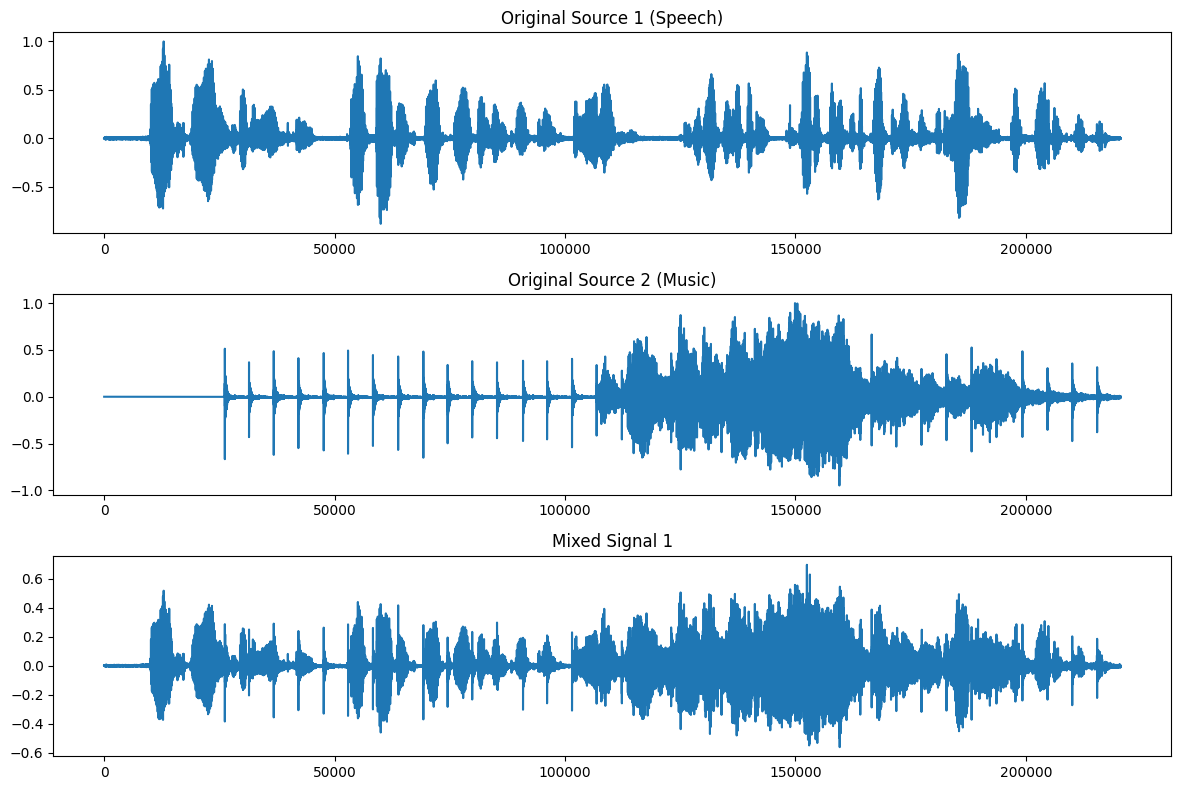

In [12]:

# --- 2. Mix Signals using a Random Mixing Matrix ---

# Using a different random seed to get a different result
np.random.seed(101)
A = np.random.rand(2, 2)  # Mixing matrix (2x2)
X = S @ A.T  # Mixed signals

print("\nMixing matrix (A):\n", A)

# Listen to mixed signals (optional, will play in notebook environments)
print("\nPlaying mixed signal 1 (check your audio output):")
ipd.display(ipd.Audio(X[:, 0], rate=sr1))

# Plot original and mixed signals
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.title("Original Source 1 (Speech)")
plt.plot(S[:, 0])
plt.subplot(3, 1, 2)
plt.title("Original Source 2 (Music)")
plt.plot(S[:, 1])
plt.subplot(3, 1, 3)
plt.title("Mixed Signal 1")
plt.plot(X[:, 0])
plt.tight_layout()
plt.show()

In [13]:


# --- 3. Apply FastICA to Separate the Signals ---

# Using a different random_state for a different result
ica = FastICA(n_components=2, random_state=101)
S_ica = ica.fit_transform(X)  # Reconstruct signals
A_est = ica.mixing_  # Estimated mixing matrix

print("\nEstimated Mixing Matrix:\n", A_est)

# --- 4. Compare Recovered Sources with Original Signals (Correlation) ---

def correlation(a, b):
    return np.corrcoef(a, b)[0, 1]

# Note: ICA cannot determine the original order or sign (polarity) of the sources.
# We check both possible pairings to find the best match.
corr_a = correlation(S[:, 0], S_ica[:, 0]) + correlation(S[:, 1], S_ica[:, 1])
corr_b = correlation(S[:, 0], S_ica[:, 1]) + correlation(S[:, 1], S_ica[:, 0])

# If corr_b is higher, it means the sources were recovered in a different order
# We swap them (and/or their signs) for correct plotting and listening.
if np.abs(corr_b) > np.abs(corr_a):
    print("Signals were recovered in swapped order.")
    S_ica_corrected = np.c_[S_ica[:, 1], S_ica[:, 0]]
else:
    print("Signals were recovered in original order.")
    S_ica_corrected = S_ica

# Check and fix sign (polarity) inversion
corr1 = correlation(S[:, 0], S_ica_corrected[:, 0])
corr2 = correlation(S[:, 1], S_ica_corrected[:, 1])

if corr1 < 0:
    print("Fixing sign of recovered signal 1")
    S_ica_corrected[:, 0] = -S_ica_corrected[:, 0]
    corr1 = -corr1
if corr2 < 0:
    print("Fixing sign of recovered signal 2")
    S_ica_corrected[:, 1] = -S_ica_corrected[:, 1]
    corr2 = -corr2

print(f"\nCorrelation Source1 <-> Recovered 1: {corr1:.4f}")
print(f"Correlation Source2 <-> Recovered 2: {corr2:.4f}")



Estimated Mixing Matrix:
 [[0.06881204 0.05232163]
 [0.02073761 0.00288035]]
Signals were recovered in swapped order.

Correlation Source1 <-> Recovered 1: 1.0000
Correlation Source2 <-> Recovered 2: 1.0000


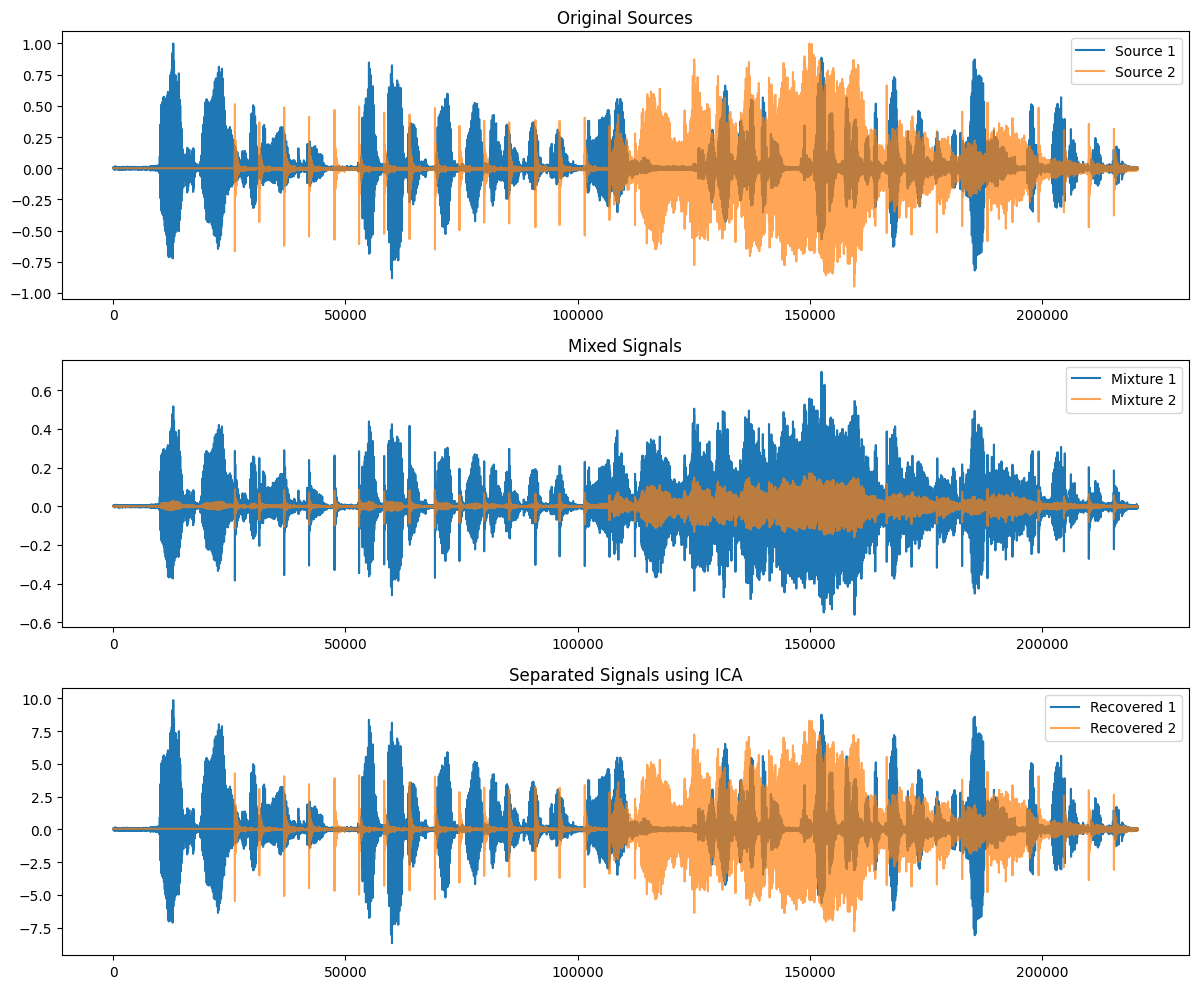

In [14]:


# --- 5. Plot Results Before and After ICA ---

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.title("Original Sources")
plt.plot(S[:, 0], label="Source 1")
plt.plot(S[:, 1], label="Source 2", alpha=0.7)
plt.legend()

plt.subplot(3, 1, 2)
plt.title("Mixed Signals")
plt.plot(X[:, 0], label="Mixture 1")
plt.plot(X[:, 1], label="Mixture 2", alpha=0.7)
plt.legend()

plt.subplot(3, 1, 3)
plt.title("Separated Signals using ICA")
plt.plot(S_ica_corrected[:, 0], label="Recovered 1")
plt.plot(S_ica_corrected[:, 1], label="Recovered 2", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


In [15]:


# --- 6. Listen to Recovered Audio ---

# Normalize for playback
S_ica_norm = S_ica_corrected / np.max(np.abs(S_ica_corrected))

print("\nRecovered Audio 1:")
ipd.display(ipd.Audio(S_ica_norm[:, 0], rate=sr1))

print("\nRecovered Audio 2:")
ipd.display(ipd.Audio(S_ica_norm[:, 1], rate=sr1))


Recovered Audio 1:



Recovered Audio 2:
